
<h1 style=" text-align:center; color:Red; font-size:40px; display: block;"> <u><b><i>Malaria Image Clasification with CNN, ResNet50 and VGG19 🦟🦟</i></b></u> </h1>
<p style="text-align:center; ">
<img src="https://cdn-prod.medicalnewstoday.com/content/images/articles/150/150670/malaria-is-passed-on-by-the-anopheles-mosquito.jpg" style='width: 400px;'>
</p>


# Importing The Modules

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from tensorflow.keras.applications.resnet import ResNet50
from keras.models import *
from keras.layers import *
import keras
import warnings
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import optimizers
from keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3, preprocess_input
warnings.filterwarnings('ignore')



# Reading The File Names

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 663M/675M [00:05<00:00, 135MB/s]
100% 675M/675M [00:05<00:00, 121MB/s]


In [6]:
!unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

# Data Preparation

In [7]:
def data_prep(parasitized,uninfected):

    parasitized= ["/content/cell_images/Parasitized" + '/' +  parasitize for parasitize in parasitized]
    uninfected= ["/content/cell_images/Uninfected" + '/' +  uninfect for uninfect in uninfected]

    labels = len(parasitized)*['parasitized'] + len(uninfected)*['uninfected']
    data = parasitized + uninfected

    return pd.DataFrame({'Image_Path': data , 'Labels': labels})


df = data_prep(os.listdir('/content/cell_images/Parasitized'), os.listdir('/content/cell_images/Uninfected'))
df.head()
df.shape

(27560, 2)

# Displaying 5 Images For Each Of The Two Labels

Displaying 5 Parasitized Images: 



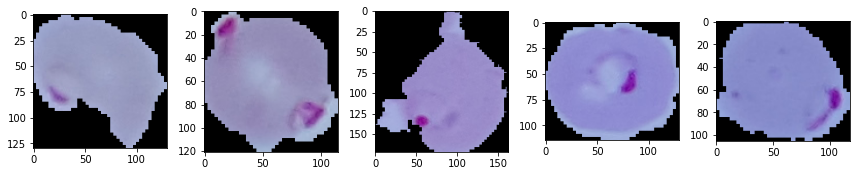


Displaying 5 Uninfected Images: 



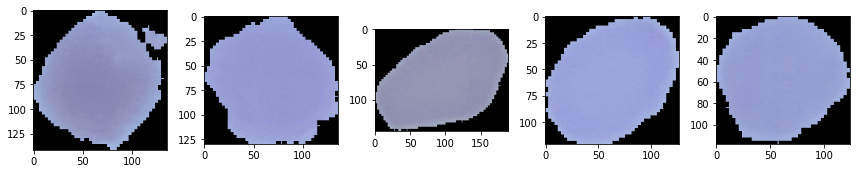

In [8]:

print("Displaying 5 Parasitized Images: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'parasitized']['Image_Path'][i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


print()
print("Displaying 5 Uninfected Images: ")
print()
plt.figure(figsize = (12,12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(df[df['Labels'] == 'uninfected']['Image_Path'].reset_index(drop=True)[i])
    plt.imshow(img)
    plt.tight_layout()
plt.show()


# Distribution Of Samples

Text(0.5, 1.0, 'Distribution of samples according to the categories')

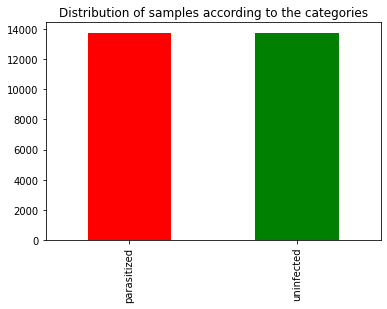

In [9]:
df['Labels'].value_counts().plot(kind = 'bar', color = ['red', 'green'])
plt.title('Distribution of samples according to the categories')

# Augmenting The Data

In [10]:

train, test = train_test_split(df, test_size = .20)

img_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest', validation_split=0.2)
                               
                               
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    #tf.keras.callbacks.ModelCheckpoint(filepath=''),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [11]:
def plot_loss_and_accuracy(mo_fit):
    accuracy = mo_fit.history['accuracy']
    loss = mo_fit.history['loss']
    validation_loss = mo_fit.history['val_loss']
    validation_accuracy = mo_fit.history['val_accuracy']



    plt.figure(figsize=(15, 7))
    plt.subplot(2, 2, 1)
    plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
    plt.plot(range(len(accuracy)), validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Accuracy : Training Vs Validation ')



    plt.subplot(2, 2, 2)
    plt.plot(range(len(accuracy)), loss, label='Training Loss')
    plt.plot(range(len(accuracy)), validation_loss, label='Validation Loss')
    plt.title('Loss : Training Vs Validation ')
    plt.legend(loc='upper right')
    plt.show()


# Building CNN

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 45s 343ms/step - loss: 4.3848 - accuracy: 0.5440 - val_loss: 0.6856 - val_accuracy: 0.5620
Epoch 2/4
100/100 [==============================] - 36s 359ms/step - loss: 0.6877 - accuracy: 0.5300 - val_loss: 0.6928 - val_accuracy: 0.5180
Epoch 3/4
100/100 [==============================] - 34s 344ms/step - loss: 0.6931 - accuracy: 0.5330 - val_loss: 0.6830 - val_accuracy: 0.5610
Epoch 4/4
100/100 [==============================] - 34s 343ms/step - loss: 0.6861 - accuracy: 0.5480 - val_loss: 0.6888 - val_accuracy: 0.5520


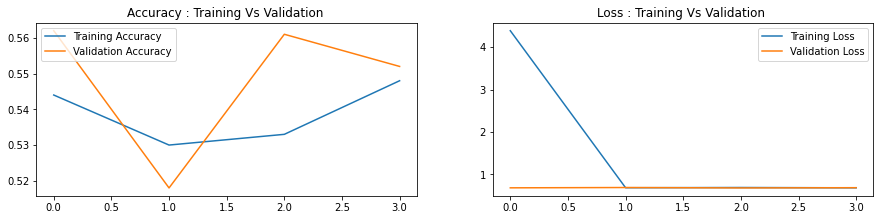

In [12]:
def cnn_model(df, train, test, my_callbacks):
    
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    model1 = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=32, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Conv2D(kernel_size=(3,3), input_shape=(224,224,3) ,filters=64, activation='relu', padding='same'),
          tf.keras.layers.MaxPool2D(pool_size=(2,2)),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(rate=0.5),
          tf.keras.layers.Dense(1, activation='sigmoid')
  ])
    model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    model_history = model1.fit_generator(generator = x_train, 
                   steps_per_epoch = 100,
                   epochs = 4 ,
                   validation_data = x_test,
                   validation_steps = 100, callbacks=my_callbacks)
    cnnmodel_test = [model_history,model1]
    
    return cnnmodel_test

cnnmodel_final =cnn_model(df, train, test, my_callbacks)

plot_loss_and_accuracy(cnnmodel_final[0])

    



# Building ResNet50

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/4
100/100 [==============================] - 79s 635ms/step - loss: 1.4538 - accuracy: 0.8730 - val_loss: 2.3537 - val_accuracy: 0.9420
Epoch 2/4
100/100 [==============================] - 57s 569ms/step - loss: 0.4366 - accuracy: 0.9140 - val_loss: 1.2849 - val_accuracy: 0.9440
Epoch 3/4
100/100 [==============================] - 56s 560ms/step - loss: 0.5442 - accuracy: 0.9410 - val_loss: 1.9923 - val_accuracy: 0.9460
Epoch 4/4
100/100 [==============================] - 56s 559ms/step - loss: 0.7876 - accuracy: 0.9410 - val_loss: 1.7651 - val_accuracy: 0.9430


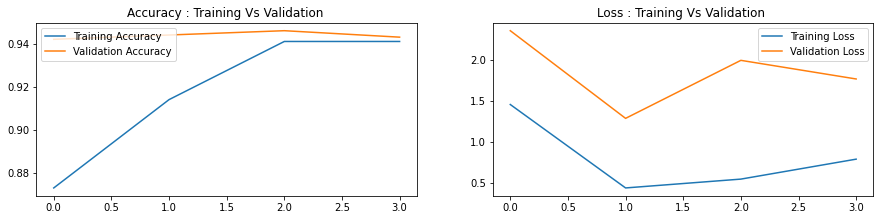

In [13]:
def resnet_model(df, train, test, my_callbacks):
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    resnet_model=ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
    model2=Sequential()
    model2.add(resnet_model)
    model2.add(Flatten())
    model2.add(Dense(1024,activation='relu'))
    model2.add(Dropout(0.5))
    model2.add(Dense(1,activation='sigmoid'))
    model2.compile(optimizer=optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    
    model_history = model2.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100,
    epochs = 4, callbacks=my_callbacks)

    
    
    resnettest_model = [model_history,model2]
    
    return resnettest_model

resnet_final = resnet_model(df, train, test, my_callbacks)    
plot_loss_and_accuracy(resnet_final[0])

# Building VGG 19

Found 17637 validated image filenames belonging to 2 classes.
Found 1102 validated image filenames belonging to 2 classes.
80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/20
100/100 [==============================] - 74s 676ms/step - loss: 1.3342 - accuracy: 0.5210 - val_loss: 0.2487 - val_accuracy: 0.8990
Epoch 2/20
100/100 [==============================] - 64s 642ms/step - loss: 0.5166 - accuracy: 0.7620 - val_loss: 0.2289 - val_accuracy: 0.9300
Epoch 3/20
100/100 [==============================] - 64s 642ms/step - loss: 0.3188 - accuracy: 0.9120 - val_loss: 0.2052 - val_accuracy: 0.9380
Epoch 4/20
100/100 [==============================] - 64s 641ms/step - loss: 0.2538 - accuracy: 0.9260 - val_loss: 0.2854 - val_accuracy: 0.9480
Epoch 5/20
100/100 [==============================] - 67s 669ms/step - loss: 0.2751 - accuracy: 0.9380 - val_loss: 0.2096 - val_accuracy: 0.9340


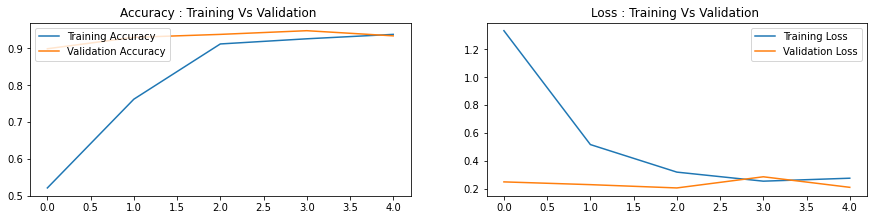

In [14]:
def vgg19_model(df, train, test, my_callbacks):
    x_train =  img_datagen.flow_from_dataframe(dataframe = train,  x_col='Image_Path', y_col='Labels',  class_mode='binary',target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='training')
    x_test = img_datagen.flow_from_dataframe(dataframe = test,  x_col='Image_Path', y_col='Labels',class_mode='binary',  target_size=(224,224), shuffle=False, batch_size=10, seed=10, subset='validation')
    
    vgg19_model = VGG19(input_shape=(224,224,3), weights='imagenet',include_top=False)
    model3=Sequential()
    model3.add(vgg19_model)
    model3.add(Flatten())
    model3.add(Dense(1024,activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(1,activation='sigmoid'))
    model3.compile(optimizer=optimizers.RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
    
    model_history = model3.fit(
    x_train,
    steps_per_epoch=100,
    validation_data=x_test,
    validation_steps=100, 
    epochs = 20 , callbacks=my_callbacks)
    vgg19 = [model_history, model3]
    return vgg19
    
vgg19Model=vgg19_model(df, train, test, my_callbacks)

plot_loss_and_accuracy(vgg19Model[0])


In [15]:
cnnmodel_final[1].save('cnn_model.h5')
resnet_final[1].save('resnet_model.h5')
vgg19Model[1].save('vgg19_model.h5')


# do stuff with model2 (e.g. predict()

In [16]:
cnn_img = load_model('cnn_model.h5')
resnet_img=load_model('resnet_model.h5')
vgg19_img= load_model('vgg19_model.h5')

In [17]:
#img = "/content/cell_images/Parasitized"

# Getting the first Four images 
#ImgDir = list(os.listdir(img)) 
#ImgDir = ImgDir[:3] 

# Loading Just a random image from the Parasitized images folder. 
imagePath ="/content/cell_images/Uninfected/C106P67ThinF_IMG_20150924_102245_cell_76.png"

# Displaying the full path to the parasitized image we want to use for prediction. 
print(imagePath)

/content/cell_images/Uninfected/C106P67ThinF_IMG_20150924_102245_cell_76.png


Loaded Image Shape: (109, 139, 3)
[[0.5317905]]


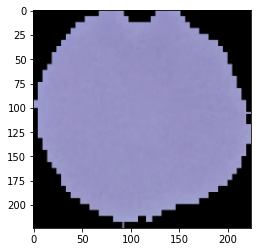

uninfected


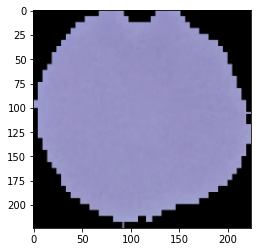

uninfected


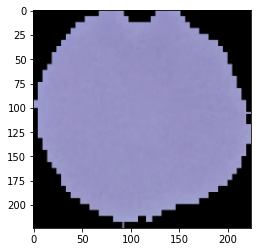

uninfected


In [18]:
imagePath ="/content/cell_images/Uninfected/C106P67ThinF_IMG_20150924_102245_cell_76.png"
img = cv2.imread(imagePath); 

# Setting the dimensions for the loaded image to be converted into and displaying the shape of the image 
print("Loaded Image Shape: {}".format(img.shape)); 
dim = (224, 224); 

# Resizing the image 
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA); 
plt.grid(False) 
#plt.imshow(img) 
#plt.show() 

# Expanding the image dimensions 
image = np.expand_dims(img, axis = 0); 

# Making Final Predictions 
result1 = cnn_img.predict(image)
result2 = resnet_img.predict(image)
result3 = vgg19_img.predict(image)
print(result1)

if result1 > 0.5:
  a='uninfected'
else:
  a='Infected'
plt.imshow(img) 
plt.show()
print(a)

if result2 > 0.5:
  b='uninfected'
else:
  b='Infected'
plt.imshow(img) 
plt.show()
print(b)

if result3 > 0.5:
  c='uninfected'
else:
  c='Infected'
plt.imshow(img) 
plt.show()
print(c)



# Creating a loop to get the actual predicted class 
#for key, value in (x_train.class class_indices.items()): 
    #if value == result: 
        #print("The Predicted Class is: {}".format(key))

# Conclusion

> **It can be seen VGG19 is performing the best in all the 4 models worked on here.**

> **InceptionV3 is performing the worst whereas the other two models are performing almost the same.**